<a href="https://colab.research.google.com/github/Ido787/ReadMyLips/blob/hyper-params/Adi_Lip_Reading_Backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import Dependencies

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown
import tempfile
import shutil
from matplotlib import pyplot as plt
from keras.models import Sequential 
from keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

# Build Data Loading Functions

In [ ]:
selected_speakers = [1]

In [ ]:
invalid_speakers = [21]
base_dataset_URL = 'https://spandh.dcs.shef.ac.uk/gridcorpus'

get_videos_url = lambda speaker_index : f'{base_dataset_URL}/s{speaker_index}/video/s{speaker_index}.mpg_vcd.zip'
get_alignments_url = lambda speaker_index : f'{base_dataset_URL}/s{speaker_index}/align/s{speaker_index}.tar'

cache_dir = '/content/data'
alignment_dir = f'{cache_dir}/alignments'
videos_dir = f'{cache_dir}/videos'

speakers = [speaker for speaker in range(1, 36) if speaker in selected_speakers and speaker not in invalid_speakers]

if not (os.path.isdir(alignment_dir) or os.path.isdir(videos_dir)):
  with tempfile.TemporaryDirectory() as tmpdir:
    for speaker_index in speakers:
      print(f'Downloading speaker {speaker_index}:')
      
      alignments_path = f'alignments/s{speaker_index}'
      tf.keras.utils.get_file(None, get_alignments_url(speaker_index), extract=True,
                                      cache_dir=tmpdir, cache_subdir = alignments_path)    
      shutil.move(f'{tmpdir}/{alignments_path}/align', f'{alignment_dir}/s{speaker_index}')

      tf.keras.utils.get_file(None, get_videos_url(speaker_index), extract=True,
                                      cache_dir=tmpdir, cache_subdir = 'videos')    
      shutil.move(f'{tmpdir}/videos/s{speaker_index}', f'{videos_dir}/s{speaker_index}')

In [ ]:
def load_video(path: str) -> List[float]: 
      cap = cv2.VideoCapture(path)
      
      # Preprocessing
      frames = []
      for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
          ret, frame = cap.read()
          frame = tf.image.rgb_to_grayscale(frame)
          frames.append(frame[190:236,80:220,:])

      cap.release()
      
      mean = tf.math.reduce_mean(frames)
      std = tf.math.reduce_std(tf.cast(frames, tf.float32))

      return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")

num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
char_to_num(['h','a','b','a', 'n', 'i'])

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([ 8,  1,  2,  1, 14,  9])>

In [ ]:
num_to_char([8, 1, 2, 1, 14, 9])

<tf.Tensor: shape=(6,), dtype=string, numpy=array([b'h', b'a', b'b', b'a', b'n', b'i'], dtype=object)>

In [ ]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(video_path: str): 
    video_path = bytes.decode(video_path.numpy())
    alignment_path = video_path.replace("videos","alignments").replace("mpg","align")
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [ ]:
test_path = './data/videos/s1/bbaf2n.mpg'

alignments- 

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

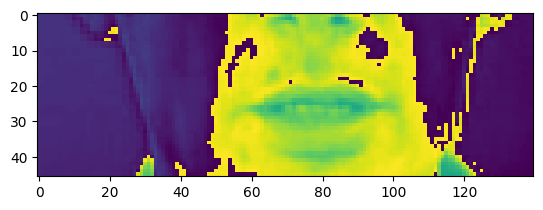

In [ ]:
plt.imshow(frames[19])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [ ]:
batch_size = 32
train_percentage = 0.1

data = tf.data.Dataset.list_files('./data/videos/*/*.mpg')
data_count = len(data)
preprocessed_data = data.shuffle(data_count, reshuffle_each_iteration=False).map(mappable_function).prefetch(tf.data.AUTOTUNE)

train_count = int(train_percentage * data_count)

# Added for split 
# Batch size is 2 hard coded, bigger batch sizes caused problems
train = preprocessed_data.take(train_count).padded_batch(2, padded_shapes=([75,None,None,None],[40]))
test = preprocessed_data.skip(train_count).padded_batch(2, padded_shapes=([75,None,None,None],[40]))

# train = preprocessed_data.take(train_count)
# test = preprocessed_data.skip(train_count)

In [ ]:
print('train', len(train), 'test', len(test))

train 50 test 450


In [ ]:
batch = train.as_numpy_iterator().next()

In [ ]:
batched_videos, batched_alignments = batch

In [ ]:
sample_video = batched_videos[0]
sample_alignments = batched_alignments[0]

In [ ]:
imageio.mimsave('./animation.gif', sample_video, fps=10)

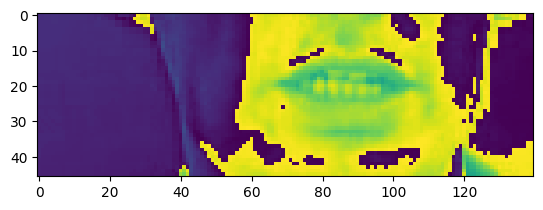

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(sample_video[35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in sample_alignments])

<tf.Tensor: shape=(), dtype=string, numpy=b'set red in a nine again'>

# 3. Design the Deep Neural Network

In [ ]:
input_shape = sample_video.shape
input_shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
# Three layers of 3D/spatiotemporal convolutions.
model.add(Conv3D(128, 3, input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

# Flattens each time slice independently.
model.add(TimeDistributed(Flatten()))

# Two layers of Bi-LSTM's.
# return_sequences=True makes the the network output a sequence of predictions, one for each time step of the input sequence.
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(.5))

# Linear transformation (dense layer) and output (softmax layer).
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_9 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_10 (Activation)  (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 75, 11, 35, 256)  0         
 g3D)                                                 

In [ ]:
yhat = model.predict(np.expand_dims(sample_video, axis=0))[0]

1/1 [==============================] - 1s 1s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat,axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b"333333333333333'jjjjjjjjbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb33333333jjjjjjjjjj">

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat])

<tf.Tensor: shape=(), dtype=string, numpy=b"333333333333333'jjjjjjjjbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb33333333jjjjjjjjjj">

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
def calculate_accuracy(y_true, y_pred):
    # Convert y_pred to label sequences by using argmax
    pred_labels, _ = tf.keras.backend.ctc_decode(y_pred, tf.shape(y_pred)[1])

    # Convert sparse tensor y_true to dense tensor for comparison
    y_true = tf.sparse.to_dense(y_true)

    # Compare the predicted labels with true labels
    matches = tf.equal(pred_labels, y_true)

    # Calculate accuracy by taking the mean of matches
    accuracy = tf.reduce_mean(tf.cast(matches, tf.float32))
    
    return accuracy

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
          data = self.dataset.next()
          yhat = self.model.predict(data[0])
          decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
          for x in range(len(yhat)):           
              print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
              print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
              print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0003), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
# temporarily take only the first batch
model.fit(train, epochs=55, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/55
50/50 [==============================] - 31s 501ms/step - loss: 111.2253 - lr: 3.0000e-04
Epoch 2/55
50/50 [==============================] - 25s 505ms/step - loss: 83.7926 - lr: 3.0000e-04
Epoch 3/55
50/50 [==============================] - 25s 505ms/step - loss: 76.2428 - lr: 3.0000e-04
Epoch 4/55
50/50 [==============================] - 25s 507ms/step - loss: 74.5173 - lr: 3.0000e-04
Epoch 5/55
50/50 [==============================] - 25s 505ms/step - loss: 71.5609 - lr: 3.0000e-04
Epoch 6/55
50/50 [==============================] - 25s 506ms/step - loss: 70.9817 - lr: 3.0000e-04
Epoch 7/55
50/50 [==============================] - 26s 511ms/step - loss: 70.8317 - lr: 3.0000e-04
Epoch 8/55
50/50 [==============================] - 26s 523ms/step - loss: 69.4352 - lr: 3.0000e-04
Epoch 9/55
50/50 [==============================] - 26s 515ms/step - loss: 68.8673 - lr: 3.0000e-04
Epoch 10/55
50/50 [==============================] - 26s 516ms/step - loss: 69.1346 - lr: 3.0000e-0

In [ ]:
loss = model.evaluate(test)

450/450 [==============================] - 235s 470ms/step - loss: 52.5476


# 5. Make a Prediction 

In [ ]:
len(test)

450

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin white with h five again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with m five soon'>]

In [ ]:
yhat_tensor = tf.convert_to_tensor(yhat)

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'la re it e aon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'la re it e aon'>]

In [ ]:
model.save_weights("adi")